In [1]:
"""
Example of using meshing_ats.py to generate a simple hillslope.

"""

import sys,os
import numpy as np
from matplotlib import pyplot as plt

# This is the standard path for SEACAS if Amanzi TPLS are built via
# bootstrap with --build-shared
try:
    import exodus3 as exodus
except ImportError:
    sys.path.append(os.path.join(os.environ['AMANZI_TPLS_DIR'],'SEACAS', 'lib'))
    import exodus


In [2]:
try:
    import meshing_ats
except ImportError:
    sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing','meshing_ats'))
    import meshing_ats

# of x and z coordinates: 20, 20


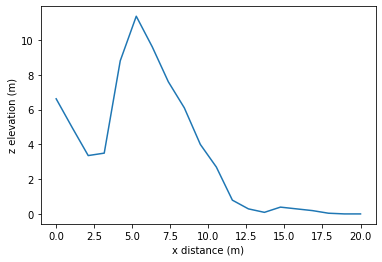

In [5]:

# Specify the top surface, given by z(x).
#
# 100m long hillslope, 10% slope, 100 cells (or 101 nodes) in x.
x = np.linspace(0,20,20)
z = [6.62,4.97,3.36,3.5,8.8,11.36,9.6,7.6,6.1,4,2.7,0.8,0.3,0.1,0.4,0.3,0.2,0.05,0.01,0.01]
print(f'# of x and z coordinates: {len(x)}, {len(z)}')

# plot the surface topography
plt.plot(x,z); plt.xlabel('x distance (m)'); plt.ylabel('z elevation (m)')
m2 = meshing_ats.Mesh2D.from_Transect(x,z,80)

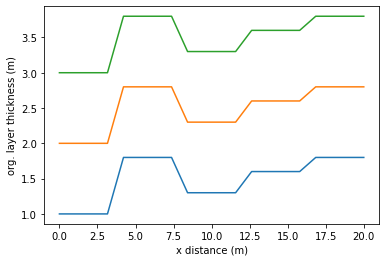

In [7]:
# In this mesh, we vary the organic layer thickness across the hillslope.
#
# Changing organic layer thickness 
def organic_thickness1(x):
    """This function is the thickness of the layer we want to vary as a function of distance down the slope"""
    if x <= 4:
        thickness = 1
    elif ((8 < x) and (x <= 12)):
        thickness = 1.3
    elif ((12 < x) and (x < 16)):
        thickness = 1.6
    else:
        thickness = 1.8
    return thickness
def organic_thickness2(x):
    """This function is the thickness of the layer we want to vary as a function of distance down the slope"""
    if x <= 4:
        thickness = 2
    elif ((8 < x) and (x <= 12)):
        thickness = 2.3
    elif ((12 < x) and (x < 16)):
        thickness = 2.6
    else:
        thickness = 2.8
    return thickness
def organic_thickness3(x):
    """This function is the thickness of the layer we want to vary as a function of distance down the slope"""
    if x <= 4:
        thickness = 3
    elif ((8 < x) and (x <= 12)):
        thickness = 3.3
    elif ((12 < x) and (x < 16)):
        thickness = 3.6
    else:
        thickness = 3.8
    return thickness
layer_1 = np.array([organic_thickness1(xx) for xx in m2.coords[:,0]])
layer_2 = np.array([organic_thickness2(xx) for xx in m2.coords[:,0]])
layer_3 = np.array([organic_thickness3(xx) for xx in m2.coords[:,0]])
plt.plot(x, layer_1[0:20]); plt.xlabel('x distance (m)'); plt.ylabel('org. layer thickness (m)');
plt.plot(x, layer_2[0:20]); plt.xlabel('x distance (m)'); plt.ylabel('org. layer thickness (m)');
plt.plot(x, layer_3[0:20]); plt.xlabel('x distance (m)'); plt.ylabel('org. layer thickness (m)');

In [9]:
# geometry of the transect extrusion
transect_layer_types = []
transect_layer_data = []
transect_layer_ncells = []

depth = []  # bookkeeping for material IDs
current_depth = 0

# We use the same dz as the above column, but because the material ID will change
# at a given depth in x, we spell it out with 1 cell per transect.
#
# 10 cells @ 5cm
dz = .05
depth.append(current_depth)
for i in range(10):
    transect_layer_types.append('constant')
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)
    
# grow dz by factors of 2, til we hit 2m
i = 0
while current_depth < 1:
    dz *= 2
    transect_layer_types.append("constant")
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)

# 2m cells to 40m
dz = 0.6
while current_depth < 6:
    transect_layer_types.append("constant")
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)
dz = 0.8
while current_depth < 16:
    transect_layer_types.append("constant")
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)

# calculate the cell centroid depth
depth = np.array(depth)
transect_layer_depth = (depth[0:-1] + depth[1:])/2

# allocate 2D matrix for material id, (# surface cells, # layers)
n_layers = len(transect_layer_data)
transect_layer_mat_ids=np.zeros((n_layers, m2.num_cells()), 'i')
for j in range(m2.num_cells()):
    for i in range(n_layers):
        if (transect_layer_depth[i] <= layer_1[j]):
            transect_layer_mat_ids[i,j] = 10
        elif ((layer_1[j] < transect_layer_depth[i]) and (transect_layer_depth[i] <= layer_2[j])):
            transect_layer_mat_ids[i,j] = 11
        elif ((layer_2[j] < transect_layer_depth[i]) and (transect_layer_depth[i] <= layer_3[j])):
            transect_layer_mat_ids[i,j] = 12
        else:
            transect_layer_mat_ids[i,j] = 13

# print out the layer information for the first column of cells
meshing_ats.summarize_extrusion(transect_layer_types, transect_layer_data, 
                                transect_layer_ncells, transect_layer_mat_ids, 0)





Cell summary:
------------------------------------------------------------
l_id	| c_id	|mat_id	| dz		| z_top
------------------------------------------------------------
 00 	| 00 	|   10 	|   0.050000 	|   0.000000
 01 	| 01 	|   10 	|   0.050000 	|   0.050000
 02 	| 02 	|   10 	|   0.050000 	|   0.100000
 03 	| 03 	|   10 	|   0.050000 	|   0.150000
 04 	| 04 	|   10 	|   0.050000 	|   0.200000
 05 	| 05 	|   10 	|   0.050000 	|   0.250000
 06 	| 06 	|   10 	|   0.050000 	|   0.300000
 07 	| 07 	|   10 	|   0.050000 	|   0.350000
 08 	| 08 	|   10 	|   0.050000 	|   0.400000
 09 	| 09 	|   10 	|   0.050000 	|   0.450000
 10 	| 10 	|   10 	|   0.100000 	|   0.500000
 11 	| 11 	|   10 	|   0.200000 	|   0.600000
 12 	| 12 	|   10 	|   0.400000 	|   0.800000
 13 	| 13 	|   11 	|   0.600000 	|   1.200000
 14 	| 14 	|   12 	|   0.600000 	|   1.800000
 15 	| 15 	|   12 	|   0.600000 	|   2.400000
 16 	| 16 	|   13 	|   0.600000 	|   3.000000
 17 	| 17 	|   13 	|   0.600000 	|   3.600000
 1

In [10]:
# make the mesh, save it as an exodus file
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, transect_layer_types,transect_layer_data, 
                                        transect_layer_ncells, transect_layer_mat_ids)
if os.path.exists('Mesh_TR010.exo'):
    os.remove('Mesh_TR010.exo')
m3.write_exodus('Mesh_TR010.exo')



You are using exodus.py v 1.20.2 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: Mesh_TR010.exo
Closing exodus file: Mesh_TR010.exo


In [11]:
# Now convert the file from "polyhedral" to "fixed format" and open it in VisIt or Paraview.
os.system("$AMANZI_TPLS_DIR/bin/meshconvert Mesh_TR010.exo Mesh_TR010a.exo")


App to convert unstructured meshes between formats
Contact: Rao Garimella (rao@lanl.gov)

Importing mesh from ExodusII file...Building classification information....Done
Exporting mesh to ExodusII/NemesisI format...Done


0